In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
import torch_geometric.transforms as T
import torch
import torch.optim as optim

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [11]:
import networkx as nx
import matplotlib.pyplot as plt

Gr = nx.DiGraph()
Gr1 = nx.DiGraph()
Gr2 = nx.DiGraph()
with open('Datasets/1992to1994.txt', 'r') as f:
    lines = f.readlines()
with open('Datasets/1994to1998.txt', 'r') as f:
    lines1 = f.readlines()
with open('Datasets/1992to1994.txt', 'r') as f:
    lines2 = f.readlines()
edges = []
count = 0

for line in lines:
    if count < 4:
        count += 1
    else:
        linesp = line.strip().split()
        edges.append((int(linesp[0]), int(linesp[1])))
        count+=1

Gr.add_edges_from(edges)
edges = []
count = 0

for line in lines1:
    if count < 4:
        count += 1
    else:
        linesp = line.strip().split()
        edges.append((int(linesp[0]), int(linesp[1])))
        count+=1
Gr1.add_edges_from(edges)
edges = []
count = 0

for line in lines2:
    if count < 4:
        count += 1
    else:
        linesp = line.strip().split()
        edges.append((int(linesp[0]), int(linesp[1])))
        count+=1
Gr2.add_edges_from(edges)

In [12]:
class EncoderForGAE(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderForGAE, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = pyg_nn.GCNConv(2 * out_channels,2* out_channels, cached=True)
        self.conv3 = pyg_nn.GCNConv(2*out_channels, out_channels, cached=True)
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return self.conv3(x, edge_index)

def train(epoch):
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    loss.backward()
    optimizer.step()

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

data = pyg_utils.convert.from_networkx(Gr2)
data1= pyg_utils.convert.from_networkx(Gr1) 
channels = 16

model = pyg_nn.GAE(EncoderForGAE(7, channels))
# labels=[0,1,2,3,4,5]
data.train_mask = data.val_mask = data.test_mask = data.y = None
transform=T.RandomLinkSplit(add_negative_train_samples=True)
data_train,data_val,data_test = transform(data1)
data=pyg_utils.train_test_split_edges(data)
# data=data.num_val
print(data_train)
positive_edge_train = []
negative_edge_train = []
positive_edge_val = []
negative_edge_val = []
positive_edge_test = []
negative_edge_test = []
for i in range(0,len(data_train.edge_label)):
    if(data_train.edge_label[i]==1):
        positive_edge_train.append(data_train.edge_label_index[:,i].tolist())
    else:
        negative_edge_train.append(data_train.edge_label_index[:,i].tolist())
for i in range(0,len(data_val.edge_label)):
    if(data_val.edge_label[i]==1):
        positive_edge_val.append(data_val.edge_label_index[:,i].tolist())
    else:
        negative_edge_val.append(data_val.edge_label_index[:,i].tolist())
for i in range(0,len(data_test.edge_label)):
    if(data_test.edge_label[i]==1):
        positive_edge_test.append(data_test.edge_label_index[:,i].tolist())
    else:
        negative_edge_test.append(data_test.edge_label_index[:,i].tolist())
data.x=torch.ones(data.num_nodes,7)
x, train_pos_edge_index = data.x, data.train_pos_edge_index
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, 201):
    train(epoch)
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    if epoch % 10 == 0:
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

/home/ameya/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(edge_index=[2, 98268], num_nodes=17362, edge_label=[196536], edge_label_index=[2, 196536])
Epoch: 010, AUC: 0.6493, AP: 0.6799
Epoch: 020, AUC: 0.6529, AP: 0.6810
Epoch: 030, AUC: 0.6533, AP: 0.6799
Epoch: 040, AUC: 0.6554, AP: 0.6817
Epoch: 050, AUC: 0.6509, AP: 0.6764
Epoch: 060, AUC: 0.6503, AP: 0.6793
Epoch: 070, AUC: 0.6465, AP: 0.6718
Epoch: 080, AUC: 0.6446, AP: 0.6697
Epoch: 090, AUC: 0.6417, AP: 0.6719
Epoch: 100, AUC: 0.6395, AP: 0.6669
Epoch: 110, AUC: 0.6370, AP: 0.6648
Epoch: 120, AUC: 0.6349, AP: 0.6661
Epoch: 130, AUC: 0.6286, AP: 0.6573
Epoch: 140, AUC: 0.6305, AP: 0.6628
Epoch: 150, AUC: 0.6291, AP: 0.6615
Epoch: 160, AUC: 0.6289, AP: 0.6614
Epoch: 170, AUC: 0.6261, AP: 0.6569
Epoch: 180, AUC: 0.6228, AP: 0.6565
Epoch: 190, AUC: 0.6222, AP: 0.6527
Epoch: 200, AUC: 0.6180, AP: 0.6478


/home/ameya/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(num_nodes=17362, val_pos_edge_index=[2, 1508], test_pos_edge_index=[2, 3017], train_pos_edge_index=[2, 51296], train_neg_adj_mask=[17362, 17362], val_neg_edge_index=[2, 1508], test_neg_edge_index=[2, 3017], x=[17362, 7])


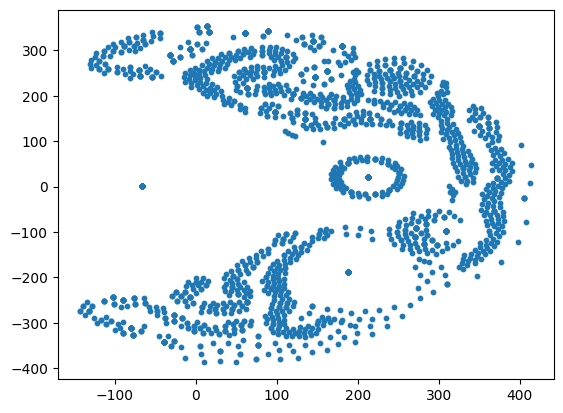

In [13]:

data = pyg_utils.convert.from_networkx(Gr1)
data=pyg_utils.train_test_split_edges(data)
data.x=torch.ones(data.num_nodes,7)
model.eval()
colors=[]
print(data)
z = model.encode(data.x, data.test_pos_edge_index)

color_list = ["red", "black", "green", "yellow", "purple", "brown", "pink", "gray", "olive", "cyan","orange"]
embs=z
# colors += [color_list[y] for y in loader[1].y]

# embs = torch.cat(embs, dim=1)
xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))
plt.scatter(xs, ys, s=10)
plt.show()
emb_mappings=z
emb_mappings=emb_mappings.detach().numpy()

In [14]:
# Link prediction using GNN node embeddings
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score,roc_auc_score
from sklearn.preprocessing import StandardScaler

In [15]:
emb_list = []
for node_index in range(0, data.num_nodes):
    # node_str = str(node_index)
    node_emb = emb_mappings[node_index]
    emb_list.append(node_emb)
emb_matrix = np.vstack(emb_list)

In [16]:
def get_edge_embeddings(edge_list):
    embs = []
    for edge in edge_list:
        node1 = edge[0]
        node2 = edge[1]
        emb1 = emb_matrix[node1]
        emb2 = emb_matrix[node2]
        edge_emb = np.multiply(emb1, emb2)
        embs.append(edge_emb)
    embs = np.array(embs)
    return embs

In [17]:
pos_train_edge_embs = get_edge_embeddings(positive_edge_train)
neg_train_edge_embs = get_edge_embeddings(negative_edge_train)
train_edge_embs = np.concatenate([pos_train_edge_embs, neg_train_edge_embs])

# Create train-set edge labels: 1 = real edge, 0 = false edge
train_edge_labels = np.concatenate([np.ones(len(positive_edge_train)), np.zeros(len(negative_edge_train))])

# Val-set edge embeddings, labels
pos_val_edge_embs = get_edge_embeddings(positive_edge_val)
neg_val_edge_embs = get_edge_embeddings(negative_edge_val)
val_edge_embs = np.concatenate([pos_val_edge_embs, neg_val_edge_embs])
val_edge_labels = np.concatenate([np.ones(len(positive_edge_val)), np.zeros(len(negative_edge_val))])

# Test-set edge embeddings, labels
pos_test_edge_embs = get_edge_embeddings(positive_edge_test)
neg_test_edge_embs = get_edge_embeddings(negative_edge_test)
test_edge_embs = np.concatenate([pos_test_edge_embs, neg_test_edge_embs])

# Create val-set edge labels: 1 = real edge, 0 = false edge
test_edge_labels = np.concatenate([np.ones(len(positive_edge_test)), np.zeros(len(negative_edge_test))])

In [18]:
edge_classifier = LogisticRegression(random_state=0)
edge_classifier.fit(train_edge_embs, train_edge_labels)

val_preds = edge_classifier.predict_proba(val_edge_embs)[:, 1]
val_roc = roc_auc_score(val_edge_labels, val_preds)
val_ap = average_precision_score(val_edge_labels, val_preds)

test_preds = edge_classifier.predict_proba(test_edge_embs)[:, 1]
test_roc = roc_auc_score(test_edge_labels, test_preds)
test_ap = average_precision_score(test_edge_labels, test_preds)

print ('GNN Validation ROC score: ', str(val_roc))
print ('GNN Validation AP score: ', str(val_ap))
print ('GNN Test ROC score: ', str(test_roc))
print ('GNN Test AP score: ', str(test_ap))

GNN Validation ROC score:  0.5892273406391838
GNN Validation AP score:  0.5350345363948088
GNN Test ROC score:  0.5886679300303913
GNN Test AP score:  0.5340398802686516
